In [1]:
%reload_kedro

2020-03-26 14:24:51,839 - root - INFO - ** Kedro project Dynamic Topic Modeling
2020-03-26 14:24:51,842 - root - INFO - Defined global variable `context` and `catalog`
2020-03-26 14:24:51,860 - root - INFO - Registered line magic `run_viz`


In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd

In [3]:
def get_document_frequency(data, wi, wj=None):
    if wj is None:
        D_wi = 0
        for l in range(len(data)):
            doc = data[l].squeeze(0)
            if len(doc) == 1: 
                continue
                #doc = [doc.squeeze()]
            else:
                doc = doc.squeeze()
            if wi in doc:
                D_wi += 1
        return D_wi
    D_wj = 0
    D_wi_wj = 0
    for l in range(len(data)):
        doc = data[l].squeeze(0)
        if len(doc) == 1: 
            doc = [doc.squeeze()]
        else:
            doc = doc.squeeze()
        if wj in doc:
            D_wj += 1
            if wi in doc:
                D_wi_wj += 1
    return D_wj, D_wi_wj 


In [4]:
def get_topic_coherence(data, vocab,n_topics,top_10=None,beta=None):
    D = len(data) ## number of docs...data is list of documents
    print('Number of doc: ', D)
    TC = []
    num_topics = n_topics
    
    for k in range(num_topics):
        print('k: {}/{}'.format(k, num_topics))
        
        if top_10 is None and beta is not None : 
            top_10 = list(beta[k].argsort()[-10:][::-1])
            top_words = [vocab[a] for a in top_10]
        elif top_10 is None and beta is None :
            raise KeyError('You must specify either a top 10 terms or a beta matrix')
        else : 
            top_10=top_10
            
        
        TC_k = 0
        counter = 0
        for i, word in enumerate(top_10):
            # get D(w_i)
            D_wi = get_document_frequency(data, word)
            p_wi=D_wi/D
            j = i + 1
            tmp = 0
            while j < len(top_10) and j > i:
                # get D(w_j) and D(w_i, w_j)
                D_wj, D_wi_wj = get_document_frequency(data, word, top_10[j])
                p_wj=D_wj/D
                p_wi_wj=D_wi_wj/D

                # get f(w_i, w_j)
                tc_pairwise = np.log(p_wi_wj/(p_wi*p_wj))/-np.log(p_wi_wj)
                # update tmp: 
                if D_wi_wj == 0 :
                    tc_pairwise=-1
                tmp += tc_pairwise
                j += 1
                counter += 1
            # update TC_k
            TC_k += tmp 
        TC_k=TC_k/counter
        print(TC_k)
        TC.append(TC_k)
        
        top_10=None
        
    print('num topics: ', len(TC))
    #TC = np.mean(TC) / counter
    print('Topic Coherence is: {}'.format(TC))
    return TC



In [5]:
def model_topic_coherence(data,vocab,n_slices,n_topics,beta=None,top_10=None) : 
    
    if beta is  None and top_10 is None : 
        raise KeyError('You must specify either a top 10 terms or a beta matrix')       
        
    tc=np.zeros((n_slices,n_topics))
    
    for timestep in range(n_slices): 
        print('-'*100)
        print('Timestep {}/{}'.format(timestep,n_slices))
        print('-'*100)
        print('\n')
        tc[timestep,:]=get_topic_coherence(data,vocab,n_topics,top_10,beta[:,timestep,:])
        
    return tc

In [4]:
import pickle
beta=loadmat('C:\\Users\\Gaspard\\statapp\\DETM-master\\results\\detm_un_K_7_Htheta_800_Optim_adam_Clip_2.0_ThetaAct_relu_Lr_0.0001_Bsz_200_RhoSize_300_L_4_minDF_100_trainEmbeddings_1_beta')
beta=beta['values']
theta=loadmat('C:\\Users\\Gaspard\\statapp\\DETM-master\\results\\detm_un_K_7_Htheta_800_Optim_adam_Clip_2.0_ThetaAct_relu_Lr_0.0001_Bsz_200_RhoSize_300_L_4_minDF_100_trainEmbeddings_1_theta')
theta=theta['values']
tokens=loadmat('C:\\Users\\Gaspard\\statapp\\DETM-master\\data_undebates_largev\\split_paragraph_0\\min_df_100\\bow_tr_tokens')
tokens=tokens['tokens']
with open('C:\\Users\\Gaspard\\statapp\\DETM-master\\data_undebates_largev\\split_paragraph_0\\min_df_100\\vocab.pkl','rb') as f :
    vocab=pickle.load(f)

In [5]:
for k in range(7) : 
    for time in [0,20,40]:
        top_10 = list(beta[k,time].argsort()[-10:][::-1])
        top_words = [vocab[a] for a in top_10]
        print('Topic {} at time {} : {}'.format(k,time,top_words))
    print('\n')

Topic 0 at time 0 : ['powers', 'charter', 'arab', 'south', 'soviet', 'problem', 'colonial', 'independence', 'delegation', 'seabed']
Topic 0 at time 20 : ['europe', 'south', 'africa', 'relations', 'aggression', 'problem', 'settlement', 'solution', 'namibia', 'republic']
Topic 0 at time 40 : ['governance', 'change', 'challenges', 'reform', 'goals', 'pakistan', 'women', 'nuclear', 'small', 'millennium']


Topic 1 at time 0 : ['europe', 'eastern', 'charter', 'africa', 'pakistan', 'african', 'republic', 'treaty', 'decade', 'history']
Topic 1 at time 20 : ['thirtyeighth', 'invasion', 'kittani', 'thirtysixth', 'twentysixth', 'thirtyninth', 'dante', 'illueca', 'twelfth', 'shorterrange']
Topic 1 at time 40 : ['detente', 'europe', 'korea', 'chile', 'colonialism', 'admission', 'guinea', 'independence', 'powers', 'arab']


Topic 2 at time 0 : ['francisco', 'vietnam', 'article', 'portuguese', 'republic', 'connexion', 'man', 'problem', 'independence', 'cambodia']
Topic 2 at time 20 : ['garba', 'fort

In [125]:
theta[0]

array([0.13361752, 0.00239025, 0.01411657, 0.349538  , 0.00807489,
       0.48959744, 0.00266534], dtype=float32)

In [159]:
topic_per(6,0.2,theta)

'0%'

### TOPIC COHERENCE OF OUR MODEL

In [152]:
theta[3550]

array([0.1994854 , 0.00268226, 0.01242366, 0.37050995, 0.00896166,
       0.40291905, 0.00301801], dtype=float32)

In [8]:
x=catalog.load('BOW_train')

2020-03-19 17:38:42,594 - kedro.io.data_catalog - INFO - Loading data from `BOW_train` (ScipySparseMatrix)...


In [12]:
def split_bow_2(bow_in, n_docs):
    indices = [[w for w in bow_in[doc,:].indices] for doc in range(n_docs)]
    indices_arr=[np.array(element) for element in indices]
    counts = [[c for c in bow_in[doc,:].data] for doc in range(n_docs)]
    counts_arr=[np.array(element) for element in counts]

    return np.array(indices_arr), np.array(counts_arr)
x2,x2c=split_bow_2(x,x.shape[0])

In [19]:
len(x2[0])

178

In [23]:
tokens[0][0].squeeze(0).squeeze()

array([  46,   86,  121,  133,  233,  257,  271,  284,  289,  308,  340,
        377,  399,  418,  425,  449,  474,  495,  507,  510,  584,  591,
        611,  614,  619,  620,  624,  650,  688,  692,  695,  707,  730,
        746,  765,  780,  794,  800,  804,  805,  816,  844,  846,  855,
        859,  877,  907,  924,  930,  931,  938,  946,  955,  993,  995,
        999, 1008, 1049, 1065, 1069, 1070, 1088, 1089, 1145, 1201, 1209,
       1218, 1255, 1265, 1292, 1298, 1303, 1313, 1349, 1362, 1380, 1408,
       1425, 1460, 1491, 1492, 1493, 1535, 1552, 1556, 1670, 1677, 1690,
       1702, 1741, 1745, 1767, 1770, 1777, 1782, 1791, 1793, 1827, 1834,
       1838, 1850, 1854, 1874, 1892, 1930, 1949, 1956, 1968, 1990, 1999,
       2001, 2029, 2058, 2063, 2124, 2130, 2161, 2179, 2212, 2220, 2224,
       2274, 2299, 2318, 2345, 2401, 2449, 2460, 2465, 2467, 2553, 2556,
       2578, 2585, 2598, 2601, 2648, 2655, 2678, 2681, 2700, 2783, 2795,
       2801, 2811, 2869, 2889, 2898, 2908, 2926, 29

Topic Coherence of our model can be calculated as : 

$\large{TC=\frac{1}{N_{times}}\sum_{t=1}^{N_{times}}\frac{1}{K}\sum_{k=1}^{K}\frac{1}{45}\sum_{i=1}^{10}\sum_{j=i+1}^{10}f(w_{i,t}^{(k)},w_{j,t}^{(k)})}$

where $\{w_{1,t}^{(k)},....,w_{10,t}^{(k)}\}$ denotes the top-10 most likely words in topic k at time t. The function $f(.,.)$ denotes the normalized pointwise mutual information such as : 

$\large{f(w_{i},w_{j})=\frac{log\frac{P(w_{i},w_{j})}{P(w_{i})P(w_{j})}}{-log(P(w_{i},w_{j})}}$

The quantity $P(w_{i}
, w_{j} )$ is the probability of words
$w_{i}$ and $w_{j}$ co-occurring in a document and $P(w_{i})$
is the marginal probability of word $w_{i}$
. We
approximate these probabilities with empirical
counts.


The idea behind topic coherence is that a coherent topic will display words that tend to occur in the same documents. In other words,
the most likely words in a coherent topic should
have high mutual information. Document models
with higher topic coherence are more interpretable
topic models.


see https://arxiv.org/pdf/1907.04907.pdf

In [9]:
tc=model_topic_coherence(data=tokens[0],vocab=vocab,beta=beta,n_topics=7,n_slices=beta.shape[1])

----------------------------------------------------------------------------------------------------
Timestep 0/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.17254826694281378
k: 1/7
0.06632336679855007
k: 2/7
0.14193281458168008
k: 3/7
0.08823290863344103
k: 4/7
0.22835501012221646
k: 5/7
0.09788534381621589
k: 6/7
0.3066602210526522
num topics:  7
Topic Coherence is: [0.17254826694281378, 0.06632336679855007, 0.14193281458168008, 0.08823290863344103, 0.22835501012221646, 0.09788534381621589, 0.3066602210526522]
----------------------------------------------------------------------------------------------------
Timestep 1/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.13803659999933948
k: 1/7
0.17797893110866705
k: 2/7
0.1675490830845829
k: 3/7
0.08446669602097992
k: 4/7
0.2069922073639138
k: 5/7
0.0891239421

C:\Users\Gaspard\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log
C:\Users\Gaspard\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


0.10741920659621763
num topics:  7
Topic Coherence is: [0.21765049641341502, 0.016413214795255586, 0.12448340708409342, 0.11570267728763385, 0.2013134789512048, 0.16622376067999692, 0.10741920659621763]
----------------------------------------------------------------------------------------------------
Timestep 4/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.1547257564262732
k: 1/7
0.02064374546065724
k: 2/7
0.16635366241598737
k: 3/7
0.1106182646416667
k: 4/7
0.23274577785603126
k: 5/7
0.13361067321809478
k: 6/7
0.1736139193256047
num topics:  7
Topic Coherence is: [0.1547257564262732, 0.02064374546065724, 0.16635366241598737, 0.1106182646416667, 0.23274577785603126, 0.13361067321809478, 0.1736139193256047]
----------------------------------------------------------------------------------------------------
Timestep 5/46
-----------------------------------------------------------------------------

0.10568356516028071
k: 1/7
0.08212635265485398
k: 2/7
0.06782586164390021
k: 3/7
0.047075309639269196
k: 4/7
0.0721985839288757
k: 5/7
0.2759851138182882
k: 6/7
0.033800837331740115
num topics:  7
Topic Coherence is: [0.10568356516028071, 0.08212635265485398, 0.06782586164390021, 0.047075309639269196, 0.0721985839288757, 0.2759851138182882, 0.033800837331740115]
----------------------------------------------------------------------------------------------------
Timestep 31/46
----------------------------------------------------------------------------------------------------


Number of doc:  6380
k: 0/7
0.25632167207744916
k: 1/7
0.2538563518244053
k: 2/7
0.08964638053734986
k: 3/7
0.04356868535462948
k: 4/7
0.028516907126551652
k: 5/7
0.07036806153179305
k: 6/7
-0.14963038133579834
num topics:  7
Topic Coherence is: [0.25632167207744916, 0.2538563518244053, 0.08964638053734986, 0.04356868535462948, 0.028516907126551652, 0.07036806153179305, -0.14963038133579834]
---------------------

In [10]:
z=0
for timestep in range(beta.shape[1]): 
    z+=np.sum(tc[timestep])/15

In [11]:
tc_mean=z/beta.shape[1]

In [12]:
print('Overall model Topic Coherence is : {}'.format(tc_mean))

Overall model Topic Coherence is : 0.06515754666850593


### TOPIC DIVERSITY OF OUR MODEL

We define topic diversity to be the
percentage of unique words in the top 25 words of
all topics. Diversity close to 0 indicates redundant
topics; diversity close to 1 indicates more varied
topics


Topic diversity in the dynamic model is calculated as 

$TD=\frac{1}{N_{times}}\sum_{t=1}^{N_{times}}TD_{t}$

where $TD_t$ denotes the Topic Diversity of our topics at time t. 


see https://arxiv.org/pdf/1907.04907.pdf

In [18]:
def _diversity_helper(beta, num_tops=25):
    list_w = np.zeros((7, num_tops))
    for k in range(7):
        gamma = beta[k, :]
        top_words = (beta[k].argsort()[-num_tops:][::-1])
        list_w[k, :] = top_words[:25]
    list_w = np.reshape(list_w, (-1))
    list_w = list(list_w)
    n_unique = len(np.unique(list_w))
    diversity = n_unique / (7 * num_tops)
    return diversity

def get_TD_by_times(beta,num_tops=25) :
    td=np.zeros(beta.shape[1],)
    for timestep in range(beta.shape[1]) : 
        td[timestep]=_diversity_helper(beta[:,timestep,:],num_tops)
    return td

In [19]:
td=np.zeros(beta.shape[1],)
for timestep in range(beta.shape[1]) : 
    td[timestep]=_diversity_helper(beta[:,timestep,:],25)

In [20]:
td_mean=np.mean(td)

In [21]:
print('Overall model Topic Diversity is : {}'.format(td_mean))

Overall model Topic Diversity is : 0.6588819875776397


### Topic Quality : *

Topic Quality is simply define by :

$TQ=TD*TC$

In [22]:
print('Topic Quality : {}'.format(round(td_mean*tc_mean,5)))

Topic Quality : 0.04293


### Visualize TC & TD over time

In [24]:
def get_top_words(beta,topic,n) : 
    return beta[topic].argsort()[-n:][::-1]

In [29]:
import matplotlib.pyplot as plt
def visualize_(topic_measure) : 
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25), dpi=80, facecolor='w', edgecolor='k')
    ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8,ax9 = axes.flatten()
    list_of_axes=[ax1, ax2, ax3, ax4, ax5, ax6, ax7,ax8,ax9]
    
    for k in range(7) : 

        #list_of_axes[k]
        list_of_axes[k].plot(topic_measure[:,k])
        list_of_axes[k].set_title('Topic Coherence of topic {}'.format(k))
        for times in [0,15,40]:
            print('\nTopic {} top words : at time {}\n'.format(k,times))
            top_words=list(get_top_words(beta[:,times,:],k,10))
            print([vocab[a] for a in top_words])
        print('-'*100)


Topic 0 top words : at time 0

['powers', 'charter', 'arab', 'south', 'soviet', 'problem', 'colonial', 'independence', 'delegation', 'seabed']

Topic 0 top words : at time 15

['africa', 'south', 'anniversary', 'nuclear', 'apartheid', 'debt', 'america', 'solution', 'crisis', 'weapons']

Topic 0 top words : at time 40

['governance', 'change', 'challenges', 'reform', 'goals', 'pakistan', 'women', 'nuclear', 'small', 'millennium']
----------------------------------------------------------------------------------------------------

Topic 1 top words : at time 0

['europe', 'eastern', 'charter', 'africa', 'pakistan', 'african', 'republic', 'treaty', 'decade', 'history']

Topic 1 top words : at time 15

['dialog', 'brunei', 'mexico', 'ambassador', 'papua', 'terrorism', 'nuclear', 'lebanon', 'pacific', 'afghanistan']

Topic 1 top words : at time 40

['detente', 'europe', 'korea', 'chile', 'colonialism', 'admission', 'guinea', 'independence', 'powers', 'arab']
-------------------------------

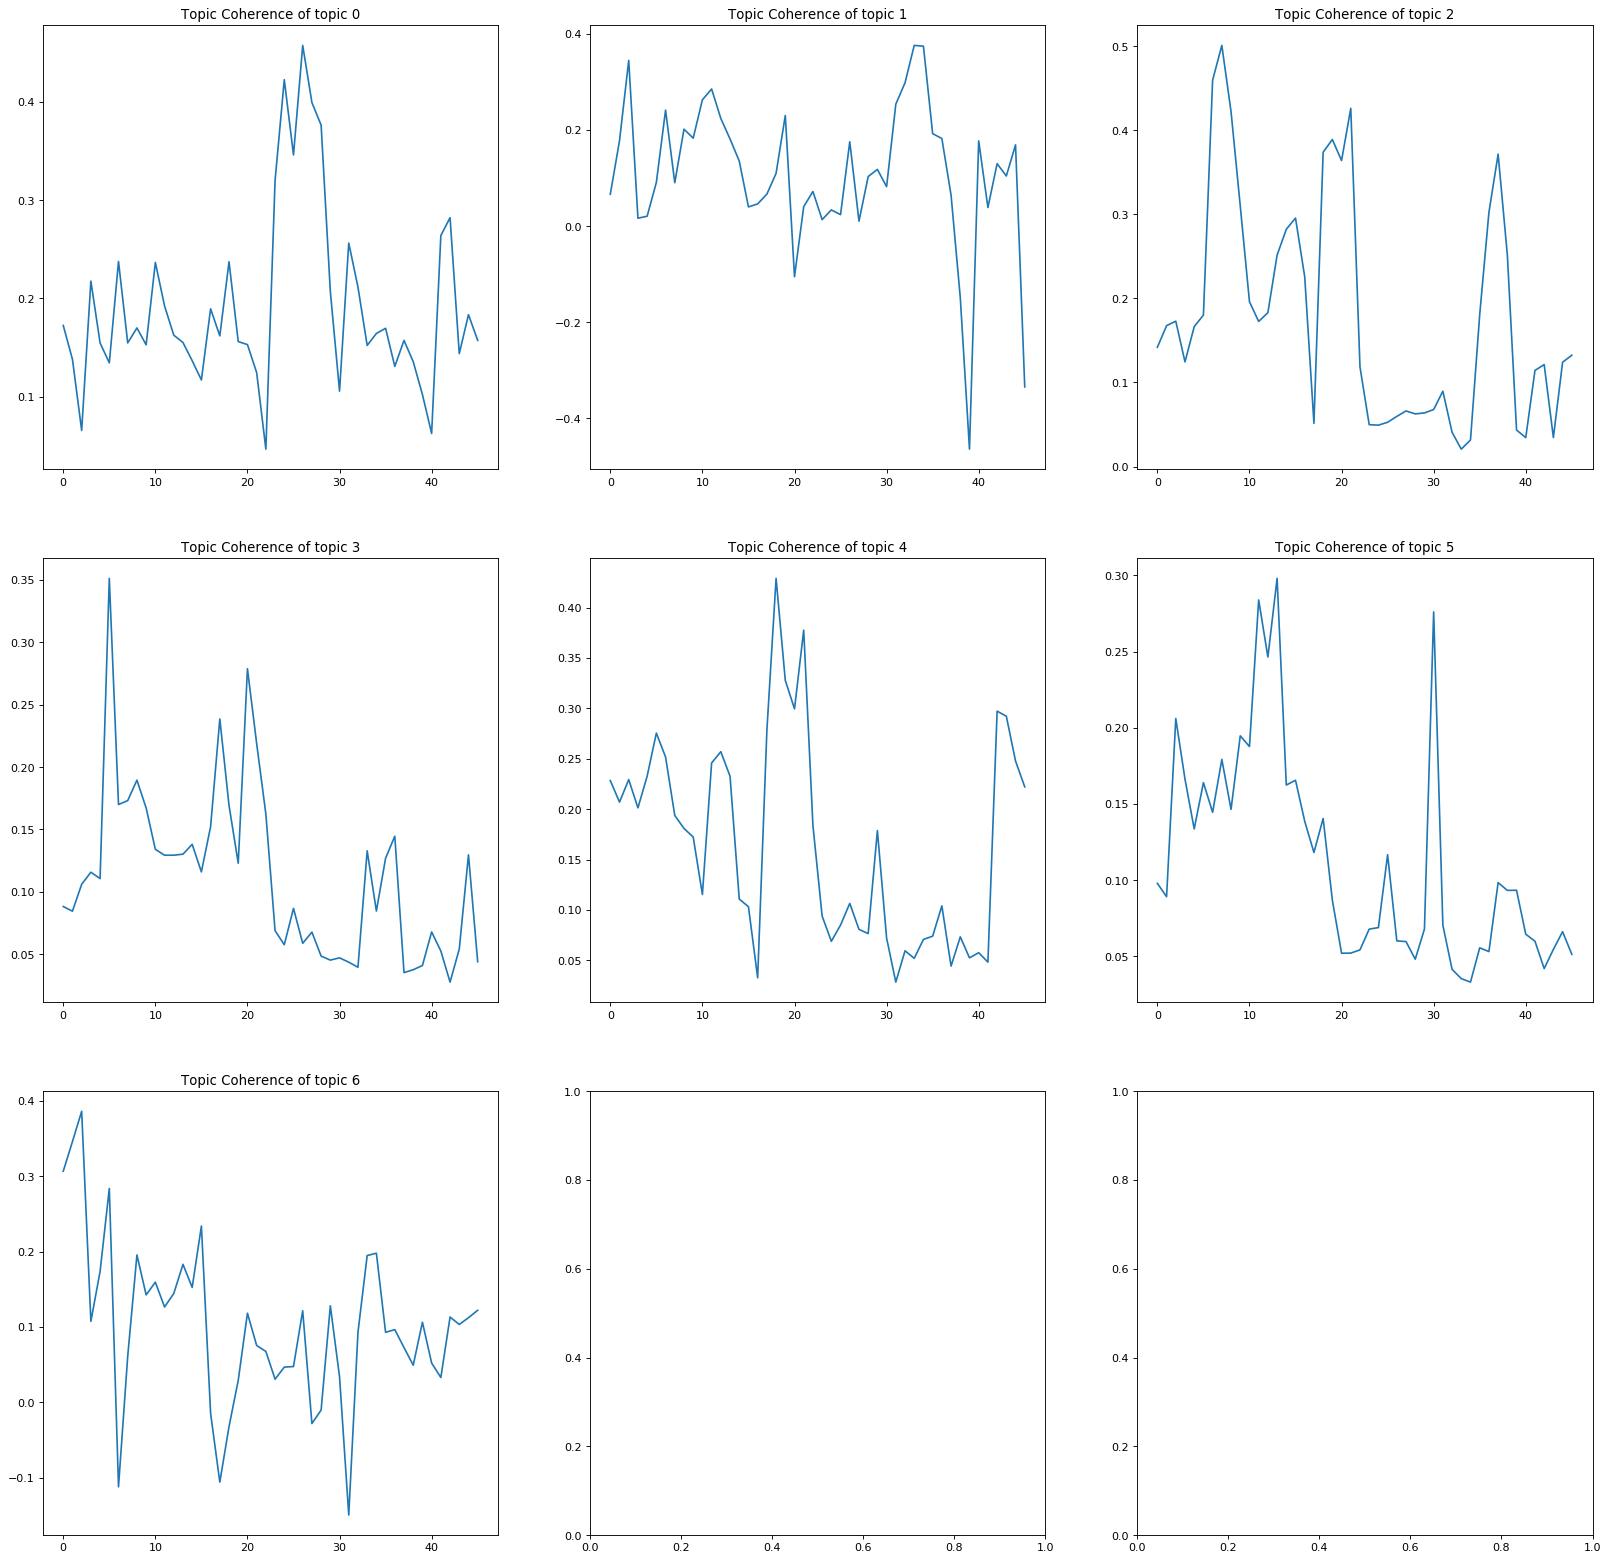

In [32]:
visualize_(tc)

### Visualize Topic diversity inter-topics by time

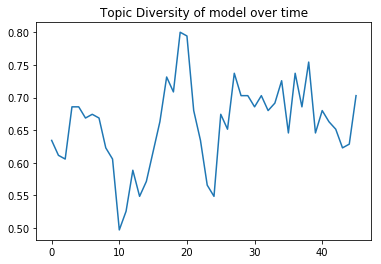

In [33]:
plt.plot(td)
plt.title('Topic Diversity of model over time')
plt.show()

### Visualize Topic diversity inter-time by topics

In [34]:
def diversity_by_topics(beta,num_tops=25) : 
    list_w = np.zeros((46, num_tops))
    for ts in range(46):
        top_words = (beta[ts].argsort()[-num_tops:][::-1])
        list_w[ts, :] = top_words
    list_w = np.reshape(list_w, (-1))
    list_w = list(list_w)
    n_unique = len(np.unique(list_w))
    diversity = n_unique / (46 * num_tops)
    return diversity

In [37]:
TD_topics=[]
for k in range(7) : 
    TD_topics.append(diversity_by_topics(beta[k,:,:]))

Text(0, 0.5, 'Diversity')

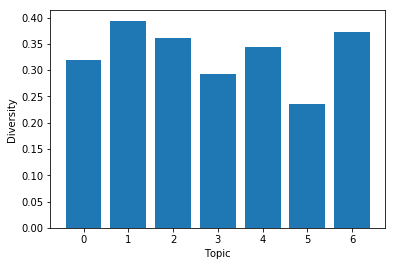

In [39]:
plt.bar(x=[i for i in range(7)],height=TD_topics)
plt.xlabel('Topic')
plt.ylabel('Diversity')

### Variance and Mean analysis of TC

In [43]:
tc_by_topic_mean=np.zeros((7,))
tc_by_topic_std=np.zeros((7,))

for k in range(7) : 
    
    tc_by_topic_mean[k]=np.mean(tc[:,k])
    tc_by_topic_std[k]=np.std(tc[:,k])
    print('-'*100)
    print('TOPIC {} :\n'.format(k))
    print('\tTC MEAN : {}'.format(tc_by_topic_mean[k]))
    print('\tTC STD : {}\n'.format(tc_by_topic_std[k]))

----------------------------------------------------------------------------------------------------
TOPIC 0 :

	TC MEAN : 0.19296617030262891
	TC STD : 0.09090212703715987

----------------------------------------------------------------------------------------------------
TOPIC 1 :

	TC MEAN : 0.10866347519745713
	TC STD : 0.15588158634041127

----------------------------------------------------------------------------------------------------
TOPIC 2 :

	TC MEAN : 0.18130368709056982
	TC STD : 0.1328683180108598

----------------------------------------------------------------------------------------------------
TOPIC 3 :

	TC MEAN : 0.11344252102618556
	TC STD : 0.06795995676820638

----------------------------------------------------------------------------------------------------
TOPIC 4 :

	TC MEAN : 0.16639340900533203
	TC STD : 0.10118135949824307

----------------------------------------------------------------------------------------------------
TOPIC 5 :

	TC MEAN : 0.112720

In [200]:
def topic_per(topic_number, thres, theta):
    cnt = 0
    for x in range(len(theta)):
        for topic, pr in enumerate(theta[x]):
            if topic == topic_number and pr > thres:
                cnt+=1
    return("{0:.0%}".format(cnt / len(theta)))

def get_n_doc_per_topic(theta) :
    z=np.zeros(len(theta))
    for x in range(len(theta)) : 
        z[x]=np.argmax(theta[x])
        
    dic_of_n={}
    for k in range(7) :
        dic_of_n[k]=len(z[z==k])
    return dic_of_n

def most_relevant_doc(theta,topic) : 
    z=[]
    for x in range(len(theta)) : 
        z.append(theta[x][topic])
    return np.argmax(z),theta[np.argmax(z)][topic]

In [201]:
most_relevant_doc(theta,5)

(1498, 0.4962488)

In [204]:
def print_data(tc,td_by_times,td_by_topic,theta,thresh=0.2) : 
    
    tc_by_topic=np.zeros((8,))
    tc_std=np.zeros((8,))
    pr=[]
    
    doc=[]
    max_pr=[]
    for k in range(7) : 
        tc_by_topic[k]=np.mean(tc[:,k]) 
        tc_std[k]=np.std(tc[:,k])
        pr.append(topic_per(k,thresh,theta))
        docs,max_prs=most_relevant_doc(theta,k)
        doc.append(docs)
        max_pr.append(round(max_prs*100,3))
    
    tc_std[7]=np.std(tc)
    tc_by_topic[7]=np.mean(tc)
    
    tc_by_topic=pd.Series(tc_by_topic,name='Topic Coherence')
    tc_std=pd.Series(tc_std,name='Topic Coherence std')
    topic=pd.Series(['1','2','3','4','5','6','7','Total'],name='Topic')
    
     
    td_by_topic=pd.Series(td_by_topic+[np.mean(td_by_topic)],name='Topic Diversity by topic')
    td_by_time=pd.Series([np.nan]*7+[np.mean(td_by_times)],name='Topic Diversity by times')
    pr=pd.Series(pr+[np.nan],name='Doc with %>{}'.format(thresh))
    
    rel_doc=pd.Series(doc,name='Most relevant doc')
    max_pr=pd.Series(max_pr,name='Max probability')
    
    n_doc_per_topic=pd.Series(get_n_doc_per_topic(theta),name='Number of docs in topic')
    return pd.DataFrame([topic,tc_by_topic,tc_std,td_by_topic,td_by_time,pr,n_doc_per_topic,rel_doc,max_pr]).T

In [205]:
print_data(tc,td,TD_topics,theta)

,Topic,Topic Coherence,Topic Coherence std,Topic Diversity by topic,Topic Diversity by times,Doc with %>0.2,Number of docs in topic,Most relevant doc,Max probability
0,1,0.192966,0.0909021,0.318261,NaN,31%,0,6340,25.1
1,2,0.108663,0.155882,0.393913,NaN,0%,0,106,0.313
2,3,0.181304,0.132868,0.361739,NaN,0%,0,2618,1.453
3,4,0.113443,0.06796,0.292174,NaN,100%,1146,4900,37.447
4,5,0.166393,0.101181,0.343478,NaN,0%,0,106,1.016
5,6,0.112721,0.0695823,0.235652,NaN,100%,5234,1498,49.625
6,7,0.101873,0.107556,0.373043,NaN,0%,0,106,0.353
7,Total,0.139623,0.113751,0.33118,0.658882,NaN,NaN,NaN,NaN


In [215]:
print('Most relevant doc of topic 5 : \n\n',' '.join([vocab[w] for w in tokens[0][1498][0]]))

Most relevant doc of topic 5 : 

 medium balanced adequate previous account specific develop common technology ashe involvement holding quality transfer neighbouring lessons urgent commitments review mdgs janeiro prior november accordance benefit dialogue energy issues purpose programme envisage growth means structures interregional conducting addressed including pillars modern establishment advance achieved complemented postconflict restore implementing communications framework underscore relevant provide improve march launch focusing specifically concrete millennium resolution sam contributed critical friendly carry trust called illicit eradication propose processes forum discussing gained venue stress agencies situations promoting cooperate plants facing inequality difficulties promoted contribute gaps achievement express participate achieve jointly awareness internet problem population strong managed wind programmes scale strategy emissions control multilateral participants largesc